# Load the data and check the stationarity of the data

### Load the data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('energy.csv')

In [3]:
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   utc_timestamp        8784 non-null   object 
 1   IT_load_new          8712 non-null   float64
 2   IT_solar_generation  8784 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


In [5]:
data.describe()

,IT_load_new,IT_solar_generation
count,8712.000000,8784.000000
mean,32262.212236,2049.831853
std,7288.629858,2845.846870
min,16716.000000,0.000000
25%,25909.500000,0.000000
50%,31654.500000,68.000000
75%,38685.750000,3923.500000
max,48986.000000,15824.000000


In [6]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   utc_timestamp        8784 non-null   datetime64[ns, UTC]
 1   IT_load_new          8712 non-null   float64            
 2   IT_solar_generation  8784 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 206.0 KB


In [8]:
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01 00:00:00+00:00,21665.0,1
1,2016-01-01 01:00:00+00:00,20260.0,0
2,2016-01-01 02:00:00+00:00,19056.0,0
3,2016-01-01 03:00:00+00:00,18407.0,0
4,2016-01-01 04:00:00+00:00,18425.0,0


### Plotting data and fill missing value

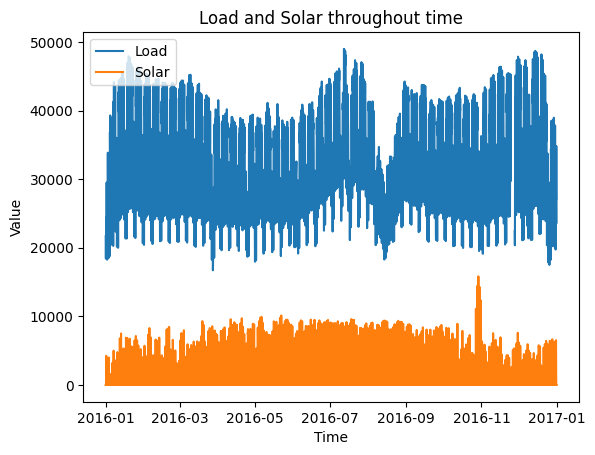

In [9]:
plt.plot(data['utc_timestamp'], data['IT_load_new'], label = 'Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Load and Solar throughout time')
plt.legend();

In [10]:
data.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [11]:
data['IT_load_new'].fillna(method = 'ffill', inplace=True)

/var/folders/qn/zzlz3xfn3sg_7htk7xqrfzfw0000gn/T/ipykernel_2359/3592397871.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['IT_load_new'].fillna(method = 'ffill', inplace=True)
/var/folders/qn/zzlz3xfn3sg_7htk7xqrfzfw0000gn/T/ipykernel_2359/3592397871.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method = 'ffill', inplace=True)


In [12]:
data.isna().sum()

utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

### ADF test after preprocessing

In [13]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    print("Test result:")
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','Number of lag used','Number of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
stationarity_test(data['IT_load_new'])

Test result:
Test Statistics          -1.197390e+01
p-value                   3.841445e-22
Number of lag used        3.700000e+01
Number of observations    8.746000e+03
Critical Value (1%)      -3.431098e+00
Critical Value (5%)      -2.861871e+00
Critical Value (10%)     -2.566946e+00
dtype: float64


In [15]:
stationarity_test(data['IT_solar_generation'])

Test result:
Test Statistics          -5.741335e+00
p-value                   6.265438e-07
Number of lag used        3.600000e+01
Number of observations    8.747000e+03
Critical Value (1%)      -3.431098e+00
Critical Value (5%)      -2.861870e+00
Critical Value (10%)     -2.566946e+00
dtype: float64


# Buiding model

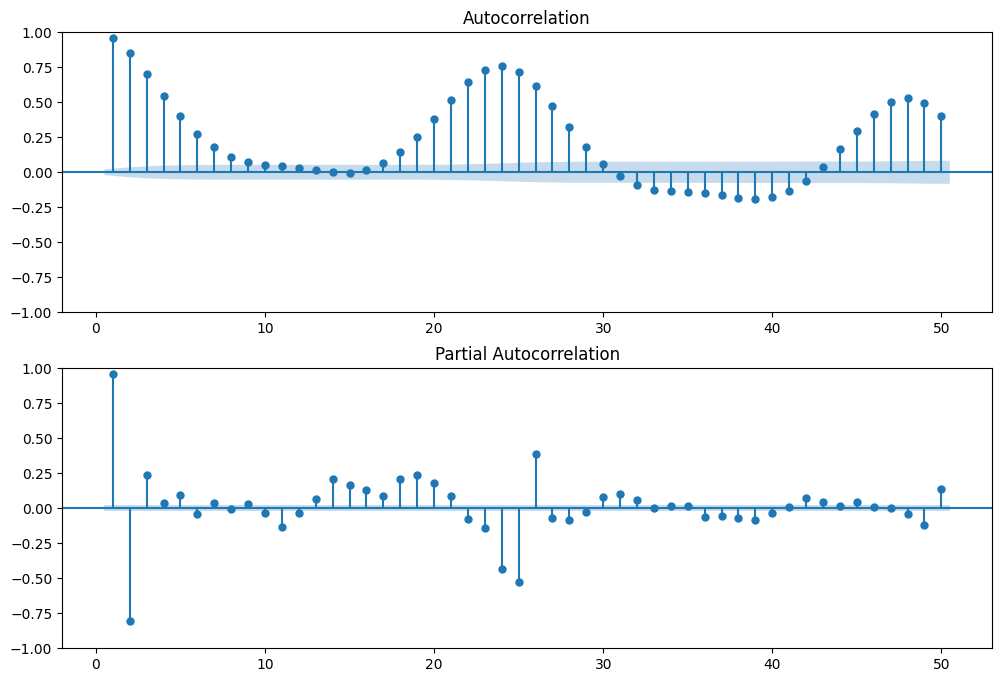

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(data['IT_load_new'],lags = 50, zero = False, ax = ax1)
plot_pacf(data['IT_load_new'],lags = 50, zero = False, ax = ax2)
plt.show();

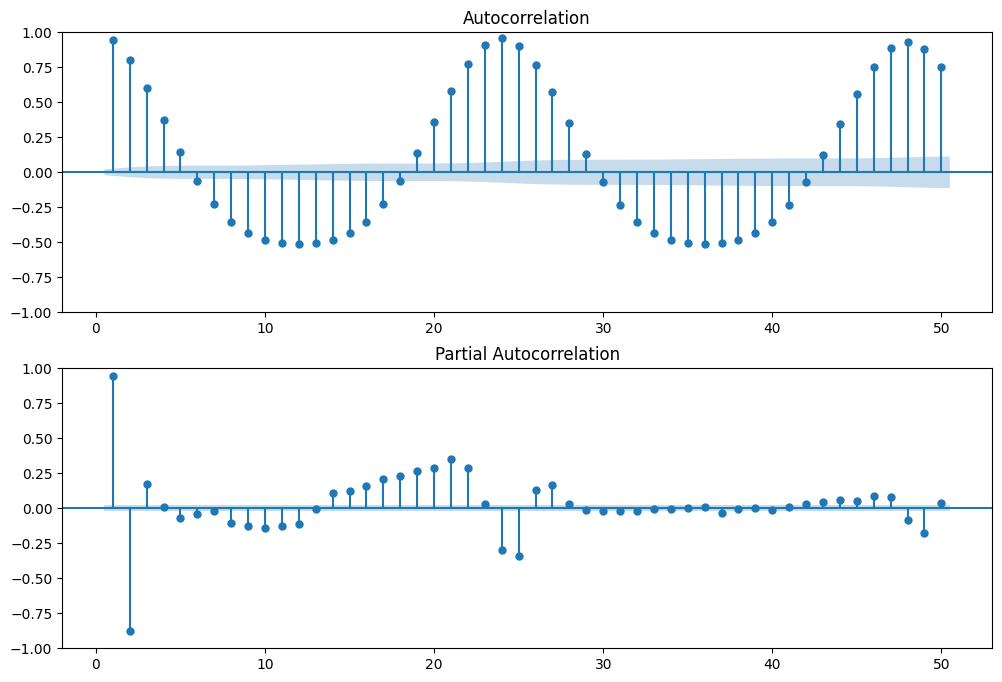

In [18]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(data['IT_solar_generation'],lags = 50, zero = False, ax = ax1)
plot_pacf(data['IT_solar_generation'],lags = 50, zero = False, ax = ax2)
plt.show();

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

train_size = int(len(data['IT_load_new'])*0.8)
train, test = data['IT_load_new'][:train_size],data['IT_load_new'][train_size:]

model = ARIMA(train,order=(2,0,2))
model_fit = model.fit()

predictions = model_fit.predict(start = len(train), end = len(train)+ len(test)-1)

rmse = sqrt(mean_squared_error(test,predictions))
print(rmse)

7714.952134841309


We can apply the same for solar data

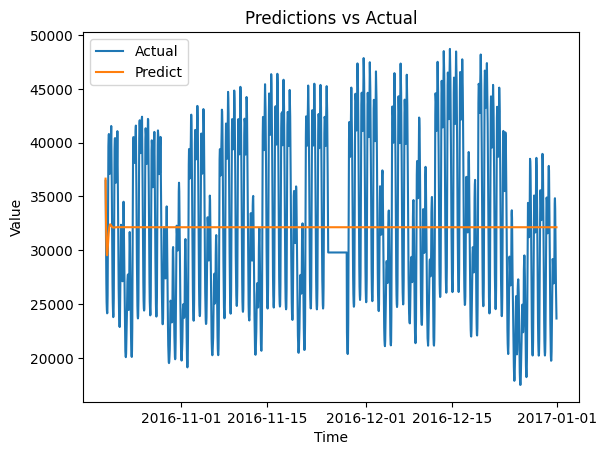

In [21]:
plt.plot(data['utc_timestamp'][train_size:], test, label = 'Actual')
plt.plot(data['utc_timestamp'][train_size:],predictions,label='Predict')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predictions vs Actual')
plt.legend();